In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json
import subprocess
from scipy.misc import imread
%matplotlib inline

from train import build_forward
from utils import train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles
from utils.rect import Rect
from utils.stitch_wrapper import stitch_rects
from evaluate import add_rectangles
import cv2

In [2]:
hypes_file = './hypes/lstm_resnet_rezoom_lung.json'
iteration = 1000000
with open(hypes_file, 'r') as f:
    H = json.load(f)
# true_json = './data/brainwash/val_boxes.json'
true_json = './data/lung_data/test.json'
# true_json = './data/lung_data/lung_train.json'
# pred_json = './output/%d_val_%s.json' % (iteration, os.path.basename(hypes_file).replace('.json', ''))
pred_json = './out/output_resnet/lstm_resnet_rezoom_lung_2017_04_26_10.53/%d_val_%s.json' % (iteration, os.path.basename(hypes_file).replace('.json', ''))
true_annos = al.parse(true_json)
print len(true_annos)
true_annos = filter(lambda x: os.path.exists('./data/lung_data/%s' % x.imageName[2:]), true_annos)
print len(true_annos)
"""
for anno in true_annos:
    pp = './data/lung_data/%s' % anno.imageName[2:]
    # print pp
    if not os.path.exists(pp):
        true_annos.remove(anno)
print len(true_annos)
"""
true_annos = filter(lambda x: os.path.exists('./data/lung_data/%s' % x.imageName[2:]), true_annos)
print len(true_annos)

2723
637
637


INFO:tensorflow:Restoring parameters from ./out/output_resnet/lstm_resnet_rezoom_lung_2017_04_26_10.53/save.ckpt-1000000
total num: 637
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
0.556345 images/sec


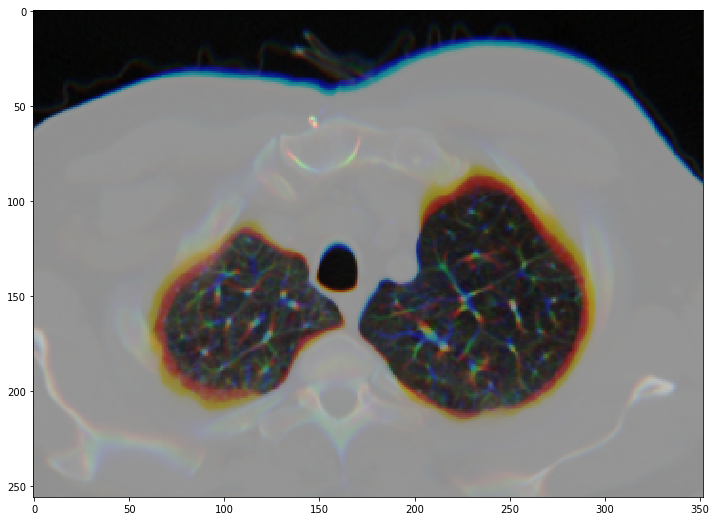

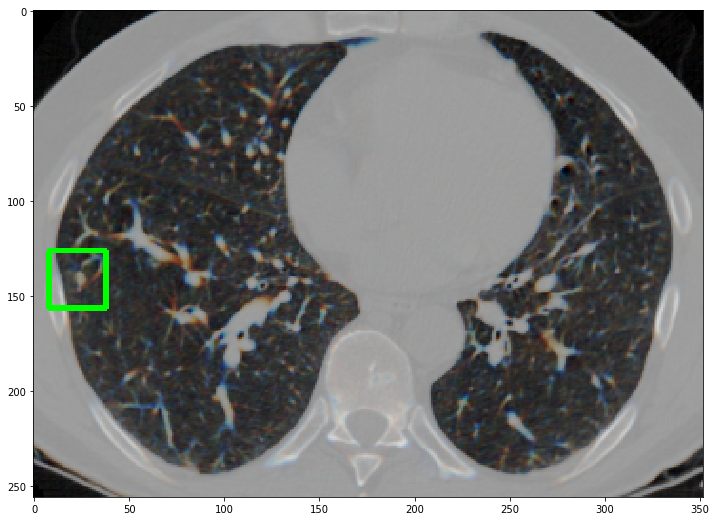

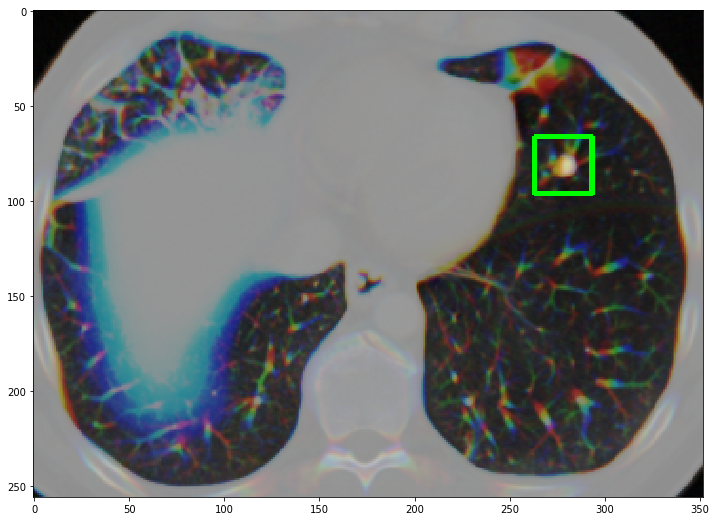

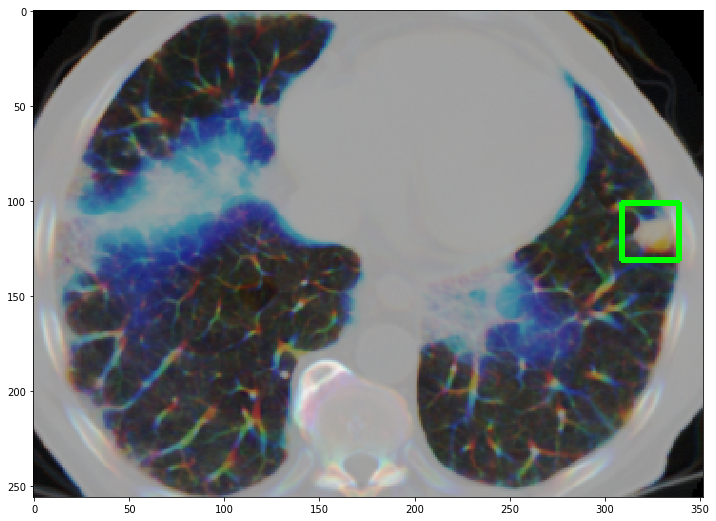

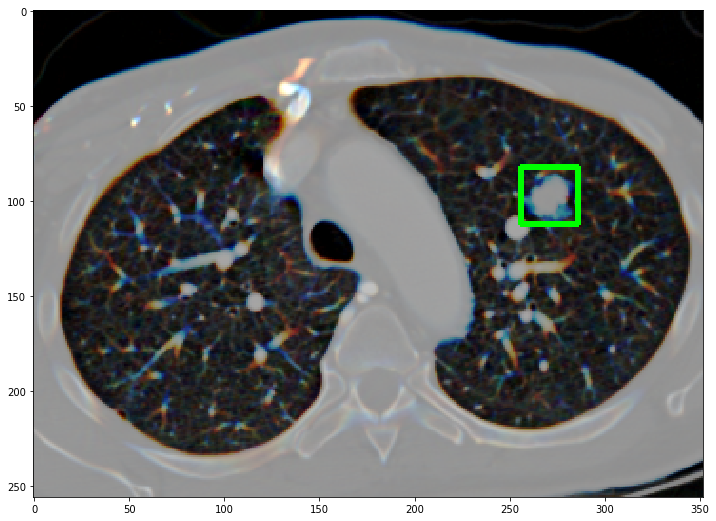

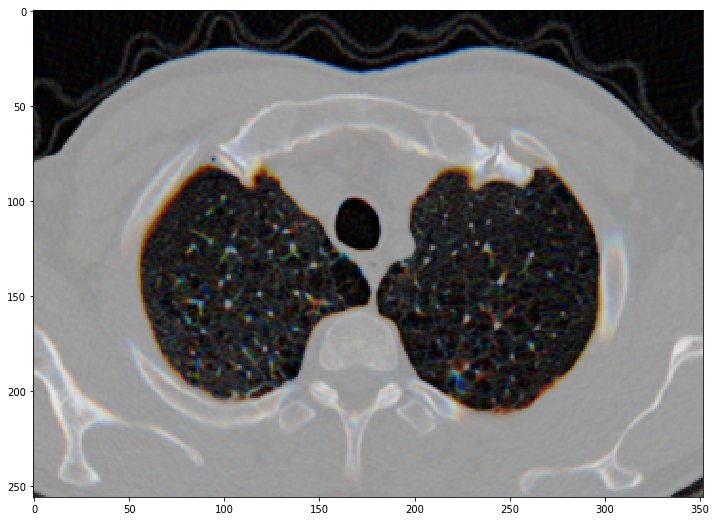

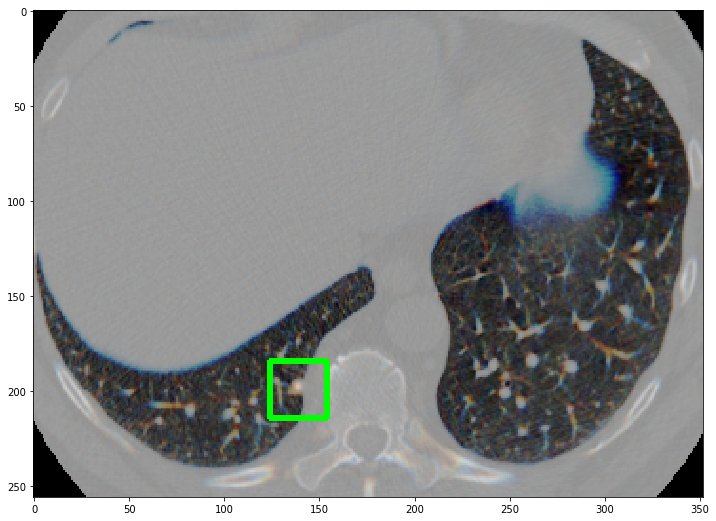

In [3]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, name='x_in', shape=[H['image_height'], H['image_width'], 3])
if H['use_rezoom']:
    pred_boxes, pred_logits, pred_confidences, pred_confs_deltas, pred_boxes_deltas = build_forward(H, tf.expand_dims(x_in, 0), 'test', reuse=None)
    grid_area = H['grid_height'] * H['grid_width']
    pred_confidences = tf.reshape(tf.nn.softmax(tf.reshape(pred_confs_deltas, [grid_area * H['rnn_len'], 2])), [grid_area, H['rnn_len'], 2])
    if H['reregress']:
        pred_boxes = pred_boxes + pred_boxes_deltas
else:
    pred_boxes, pred_logits, pred_confidences = build_forward(H, tf.expand_dims(x_in, 0), 'test', reuse=None)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './out/output_resnet/lstm_resnet_rezoom_lung_2017_04_26_10.53/save.ckpt-%d' % iteration)

    annolist = al.AnnoList()
    import time; t = time.time()
    print 'total num:', len(true_annos)
    for i in range(0, len(true_annos)):
        true_anno = true_annos[i]
        # print true_anno.imageName
        tmp = './data/lung_data/%s' % true_anno.imageName[2:]
        # print tmp
        """
        if not os.path.exists(tmp):
            print tmp
            continue
        """
        # print tmp
        # img = imread('./data/lung_data/%s' % true_anno.imageName)
        img = imread(tmp)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        pred_anno = al.Annotation()
        pred_anno.imageName = true_anno.imageName
        new_img, rects = add_rectangles(H, [img], np_pred_confidences, np_pred_boxes,
                                        use_stitching=True, rnn_len=H['rnn_len'], min_conf=0.7,
                                        show_suppressed=False)
    
        pred_anno.rects = rects
        annolist.append(pred_anno)
    
        if i % 10 == 0:
            print i
            if i % 100 == 0:
                fig = plt.figure(figsize=(12, 12))
                plt.imshow(new_img)
        """
        if i % 10 == 0 and i < 200:
            pass
            fig = plt.figure(figsize=(12, 12))
            plt.imshow(new_img)
        if i % 100 == 0:
            print(i)
        """
    avg_time = (time.time() - t) / (i + 1)
    print('%f images/sec' % (1. / avg_time))

saving:  ./out/output_resnet/lstm_resnet_rezoom_lung_2017_04_26_10.53/1000000_val_lstm_resnet_rezoom_lung.json
$ ./utils/annolist/doRPC.py --minOverlap 0.500000 ./data/lung_data/test.json ./out/output_resnet/lstm_resnet_rezoom_lung_2017_04_26_10.53/1000000_val_lstm_resnet_rezoom_lung.json
Minimum width: 0 height: 0
Asorting too large/ too small detections
minWidth: 0
minHeight: 0
maxWidth:  inf
maxHeight:  inf
#Annotations: 438
Setting up graphs ...
No annotation/detection pair found for: ./lung_data/LIDC-IDRI-0103.dat_40_.bmp frame: -1
No annotation/detection pair found for: ./lung_data/LIDC-IDRI-0103.dat_53_.bmp frame: -1
No annotation/detection pair found for: ./lung_data/LIDC-IDRI-0103.dat_54_.bmp frame: -1
No annotation/detection pair found for: ./lung_data/LIDC-IDRI-0103.dat_88_.bmp frame: -1
No annotation/detection pair found for: ./lung_data/LIDC-IDRI-0559.dat_14_.bmp frame: -1
No annotation/detection pair found for: ./lung_data/LIDC-IDRI-0559.dat_15_.bmp frame: -1
No annotatio

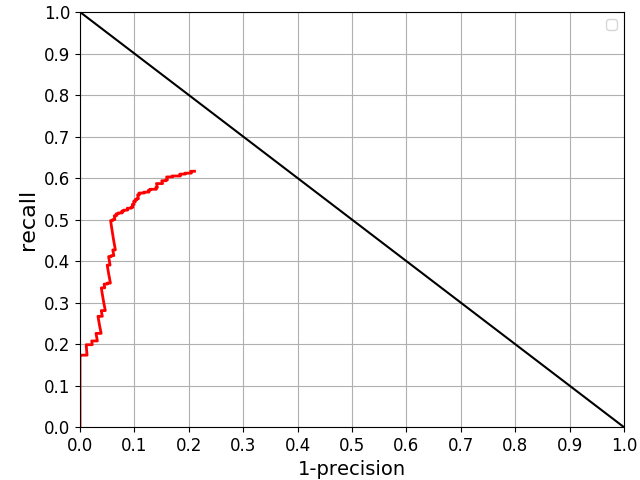

In [4]:
annolist.save(pred_json)
iou_threshold = 0.5
rpc_cmd = './utils/annolist/doRPC.py --minOverlap %f %s %s' % (iou_threshold, true_json, pred_json)
print('$ %s' % rpc_cmd)
rpc_output = subprocess.check_output(rpc_cmd, shell=True)
print(rpc_output)
txt_file = [line for line in rpc_output.split('\n') if line.strip()][-1]
output_png = 'output/results.png'
plot_cmd = './utils/annolist/plotSimple.py %s --output %s' % (txt_file, output_png)
print('$ %s' % plot_cmd)
plot_output = subprocess.check_output(plot_cmd, shell=True)
from IPython.display import Image
Image(filename=output_png) 